In [1]:
import glob
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# general IC imports
from invisible_cities.database          import load_db
from invisible_cities.core.system_of_units_c import units
adc, pes, mus = units.adc, units.pes, units.mus
NN = -999999

# IRENE
from invisible_cities.cities.components import deconv_pmt
from invisible_cities.cities.components import calibrate_pmts
from invisible_cities.cities.components import calibrate_sipms

from invisible_cities.cities.components import deconv_pmt
from invisible_cities.cities.components import calibrate_pmts
from invisible_cities.cities.components import calibrate_sipms
from invisible_cities.cities.components import zero_suppress_wfs

from invisible_cities.reco.peak_functions import split_in_peaks
from invisible_cities.reco.peak_functions import select_peaks
from invisible_cities.reco.peak_functions import select_wfs_above_time_integrated_thr
from invisible_cities.reco.peak_functions import pick_slice_and_rebin

from invisible_cities.types.ic_types import minmax

# PENTHESILEA
from invisible_cities.reco.peak_functions import rebin_times_and_waveforms

# ESMERALDA
from invisible_cities.reco.corrections_new import read_maps
from invisible_cities.reco.corrections_new import apply_all_correction
from invisible_cities.reco.corrections_new import norm_strategy

## General cut parameters

In [2]:
# S1 selection
s1emin = 40
s1wmin = 175

pmt_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

## Import raw waveforms

In [3]:
run = 7430
wfs_dir        = f"/home/gdiaz/Verify_IRENENB_corrections/DATA/{run}/rwf/"
wfs_files = glob.glob( wfs_dir + "/*" )
wfs_files.sort()

# IRENE

## Configuration Parameters

In [4]:
files_in  = wfs_files
file_out  = ""

run = 7430
n_baseline = 62400 

n_mau   = 100
thr_mau =   3 * adc

thr_csum_s1 = 0.5 * pes
thr_csum_s2 = 2.0 * pes

thr_sipm   = 1.0 * pes    
thr_sipm_type = "Common"

s1_tmin   =   0 * mus 
s1_tmax   = 790 * mus 
s1_stride =   4       
s1_lmin   =   5       
s1_lmax   =  30      
s1_rebin_stride = 1

s2_tmin   =      0 * mus 
s2_tmax   =   1601 * mus 
s2_stride =     40      
s2_lmin   =     80       
s2_lmax   = 200000       
s2_rebin_stride = 40   

thr_sipm_s2 = 5 * pes  

detector_db = "new" ## Added by me

if thr_sipm_type.lower() == "common": 
    sipm_thr = thr_sipm

### Select file and waveform

In [5]:
file_number = 0

RWFs_file = tb.open_file(files_in[file_number])
pmt_rwfs_all  = RWFs_file.root.RD.pmtrwf
sipm_rwfs_all = RWFs_file.root.RD.sipmrwf
time_stamps   = RWFs_file.root.Run.events

#select random waveform
i = int( np.random.random()* (len(time_stamps) - 1) )
event_time = time_stamps[i]


pmt_rwfs  = pmt_rwfs_all [i]
sipm_rwfs = sipm_rwfs_all[i]

RWFs_file.close()

### PMT processing

In [6]:
rwf_to_cwf = deconv_pmt    (detector_db, run, n_baseline)
pmt_cwfs   = rwf_to_cwf    (pmt_rwfs)

In [7]:
cwf_to_ccwf = calibrate_pmts(detector_db, run, n_mau, thr_mau)
pmt_ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau  = cwf_to_ccwf    (pmt_cwfs)

### SIPM processing

In [8]:
sipm_rwf_to_cal = calibrate_sipms(detector_db, run, sipm_thr)
sipm_cwfs = sipm_rwf_to_cal(sipm_rwfs)

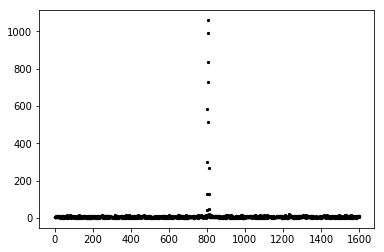

In [9]:
times = np.arange(sipm_cwfs.shape[1])
plt.scatter(times, np.sum( sipm_cwfs, axis=0), color="black", s=5 )

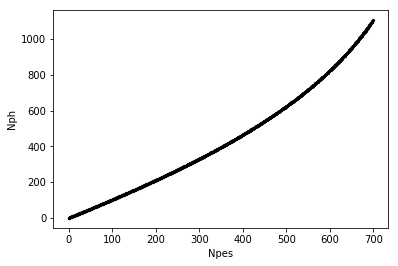

In [10]:
params = np.array( [ 6.58477685e-22,  1.50455111e-17, -2.74129372e-14,  2.03138072e-11,
                    -7.13216271e-09,  1.83113819e-06,  4.85324372e-05,  1.00393735e+00,
                    -1.89564238e-02] )
params = np.flip(params)

def pes_to_photons(Npes):
    #polynomial correction
    exp = np.array( [Npes**i for i in range(0, 9)] )
    Nph = np.sum( np.multiply(params, exp.T).T, axis=0)
    
    #identity correction
    sel = Npes<50
    Nph[sel] = Npes[sel]
    
    return Nph

Npes = np.arange(0, 700, dtype=np.float)
Nph = pes_to_photons(Npes)

plt.scatter( Npes, Nph, c="black", s=5)
plt.xlabel("Npes")
plt.ylabel("Nph");

In [11]:
corrsipm = pes_to_photons(sipm_cwfs)

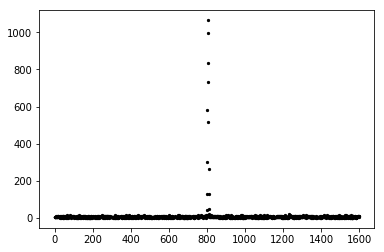

In [12]:
times = np.arange(sipm_cwfs.shape[1])
plt.scatter(times, np.sum( corrsipm, axis=0), color="black", s=5 )

### Find S1 and S2 peaks (IRENE)

In [13]:
zero_suppress = zero_suppress_wfs(thr_csum_s1, thr_csum_s2)
s1_indices, s2_indices = zero_suppress(cwf_sum, cwf_sum_mau)

In [14]:
indices_split   = split_in_peaks(s1_indices, s1_stride)
    
time    = minmax(min = s1_tmin, max = s1_tmax)
length  = minmax(min = s1_lmin, max = s1_lmax)
    
s1_selected_splits = select_peaks  (indices_split, time, length)

print("Number of S1 candidates:", len(s1_selected_splits))

Number of S1 candidates: 1


In [15]:
indices_split   = split_in_peaks(s2_indices, s2_stride)
    
time    = minmax(min = s2_tmin, max = s2_tmax)
length  = minmax(min = s2_lmin, max = s2_lmax)
    
s2_selected_splits = select_peaks  (indices_split, time, length)

print("Number of S2 candidates:", len(s2_selected_splits))

Number of S2 candidates: 1


### S1 and S2 cuts

In [16]:
# S1 cuts
if len(s1_selected_splits)==0:
    raise Exception("No S1 in event")
    
s1es, s1ws = [], []
for ss in s1_selected_splits:
    s1_pmt = np.sum( pmt_ccwfs[:, ss[0]: ss[-1]], axis=0)
    s1es.append( np.sum(s1_pmt)    )
    s1ws.append( (ss[-1]-ss[0])*25 )
s1es, s1ws = np.array(s1es), np.array(s1ws)

sel = (s1es>=s1emin) & (s1ws>=s1wmin)
idxs = np.argwhere(sel).flatten()

if len(idxs)==0:
    raise Exception("No S1 pass the cut")
elif len(idxs)>1:
    raise Exception("More than 1S1 pass the cut")
else:
    idx = idxs[0]
    s1_pmt = np.sum( pmt_ccwfs[:, s1_selected_splits[idx][0]: s1_selected_splits[idx][-1]], axis=0)
    times  = np.arange(s1_selected_splits[idx][0], s1_selected_splits[idx][-1])*25

    S1_time = times[np.argmax(s1_pmt)]
    
# S2 cut
if len(s2_selected_splits)>1:
    raise Exception("More that 1S2")

### Select and process S2 RWFs

In [17]:
times  = np.arange     (pmt_ccwfs.shape[1]) * 25 * units.ns
widths = np.full       (pmt_ccwfs.shape[1],   25 * units.ns)

indices = s2_selected_splits[0]
wfs     = pmt_ccwfs

with_sipms = True

times, rebinned_widths, s2_pmts = pick_slice_and_rebin(indices, times, widths,
                                                       wfs, 
                                                       rebin_stride = s2_rebin_stride, 
                                                       pad_zeros    = with_sipms)

In [36]:
s2_sipms = sipm_cwfs[:, s2_selected_splits[0][0] //40 : s2_selected_splits[0][-1]//40 + 1]

########## ADD PES TO PHOTON CONVERSION HERE ############
s2_sipms = pes_to_photons(s2_sipms)

# thr_sipm_s2
sipm_ids, s2_sipms = select_wfs_above_time_integrated_thr(s2_sipms, thr_sipm_s2)

In [37]:
#float32
s2_pmts  = np.float32( s2_pmts )
s2_sipms = np.float32( s2_sipms)
times    = np.float32( times   )

#pmt ids
c = np.zeros(s2_pmts.shape[0])
c[pmt_ids] = 1
s2_pmts  = np.multiply( c, s2_pmts.T ).T

# PENTHESILEA

In [38]:
qth = 5 * pes

rebin = 2

## PMT RWFs Rebinning

In [39]:
# Rebin

_, _, s2_sipms    = rebin_times_and_waveforms(times, rebinned_widths, s2_sipms,
                                              rebin_stride=rebin, slices=None)

times, _, s2_pmts = rebin_times_and_waveforms(times, rebinned_widths, s2_pmts,
                                              rebin_stride=rebin, slices=None)

### Charge cut

In [18]:
s2_pmts_penth = np.copy( s2_pmts )

sel = (s2_sipms >= qth)
s2_sipms_penth = np.where(sel, s2_sipms, 0)

no_pass_cut_slices = ~sel.any(axis=0)

### Create hits

In [19]:
datasipm = load_db.DataSiPM("new", run)
sipm_xs  = datasipm.X.values
sipm_ys  = datasipm.Y.values
n_sipms = len(sipm_ids)

X, Y = sipm_xs[sipm_ids], sipm_ys[sipm_ids]
T = (times - S1_time)/1000

In [20]:
E_per_slice = np.sum( s2_pmts_penth, axis=0)

hits = []
nn_hits = []
for t, e, q in zip(T, E_per_slice, s2_sipms_penth.T):
    if np.sum(q)==0:
        nn_hits.append( (0, 0, t, e, NN, -1) )
    else:
        E = e * q / np.sum(q)
        hits.append( (X, Y, np.full( n_sipms, t), E, q, np.full( n_sipms, -1) ) )

hits = np.array( hits )
hits = np.swapaxes(hits, axis1=1, axis2=2)
hits = np.concatenate( hits )

In [21]:
H = np.array(np.zeros(np.shape(hits)[0]), 
             dtype=[("X", int)  , ("Y", int)  , ("Z", float), 
                    ("E", float), ("Q", float), ("Ec",float)])

H["X"] = hits[:, 0]
H["Y"] = hits[:, 1]
H["Z"] = hits[:, 2]
H["E"] = hits[:, 3]
H["Q"] = hits[:, 4]
H["Ec"] = -1

#remove 0 charge hits and insert NN
sel = ~(H["Q"]==0)
H = np.insert( H[sel], 0, nn_hits)
H = np.sort( H, order="Z")

hits = H

# ESMERALDA

In [22]:
qth = 30

In [23]:
sel = (hits["Q"]>=qth)
hits["Q"][~sel] = 0

slides = np.unique( hits["Z"] )
for slide in slides:
    sel = (hits["Z"]==slide)
    slide_hits = hits[sel]
    
    q = slide_hits["Q"]
    e = slide_hits["E"]
    
    if np.sum( q ) == 0:
        idxs = np.argwhere(sel).flatten()
        hits = np.delete(hits, idxs)
        hits = np.insert(hits, 0, (0, 0, slide, np.sum(e), NN, -1))
        
    else:
        hits["E"][sel] = np.sum( e ) * q / np.sum(q)
        
sel = (hits["Q"]==0)
hits = np.delete( hits, np.argwhere(sel))
hits = np.sort(hits, order="Z")

In [24]:
# JOIN NN hits

sel = (hits["Q"]==NN)

nn_hits = hits[ sel]
hits    = hits[~sel]

slides = np.unique( hits["Z"] )

for nn_hit in nn_hits:
    
    #select slide to append
    d = np.abs( slides - nn_hit["Z"] ) 
    
    slide = slides[ np.argmin( d ) ]
    slide_hits = hits[hits["Z"]==slide]
    
    #new energy 
    new_E = np.sum(slide_hits["E"]) + nn_hit["E"]
    
    q = hits[hits["Z"]==slide]["Q"]
    Q = np.sum( q )
    
    hits["E"][hits["Z"] == slide] = new_E * q / Q

### Corrections

In [25]:
map_file = glob.glob( f"/home/gdiaz/Verify_IRENENB_corrections/DATA/{run}/map_*")[0]
maps = read_maps( map_file )

total_correction = apply_all_correction(maps, apply_temp=True,
                                        norm_strat=norm_strategy.kr)

In [26]:
X = hits["X"]
Y = hits["Y"]
Z = hits["Z"]
E = hits["E"]
Q = hits["Q"]

T = np.full(len(hits), event_time[-1]/1000)

correction_factor = total_correction(X, Y, Z, T)
Ec = correction_factor * E

hits["Ec"] = Ec
hits["Z"]  = Z * maps.t_evol.dv.mean()

In [27]:
hits

array([(-15,  5, 56.3077694 , 1459.46229362,  53.51047134, 0.00513337),
       (-15, 15, 56.3077694 , 2808.14779709, 102.95936584, 0.00969686),
       (-15, 25, 56.3077694 ,  851.12841845,  31.20620728, 0.00290031),
       ( -5,  5, 56.3077694 , 3051.88216362, 111.89576721, 0.01062303),
       ( -5, 15, 56.3077694 , 9761.22727589, 357.890625  , 0.03370595),
       ( -5, 25, 56.3077694 , 2333.52487593,  85.55754852, 0.00806828),
       (  5,  5, 56.3077694 , 1394.58910187,  51.13192749, 0.00481316),
       (  5, 15, 56.3077694 , 2722.43733044,  99.8168335 , 0.00942123),
       (  5, 25, 56.3077694 ,  978.0866492 ,  35.86106873, 0.00341159),
       (-15,  5, 57.76089801, 1527.28085675,  72.25067139, 0.00537295),
       (-15, 15, 57.76089801, 3092.30135755, 146.28668213, 0.01068075),
       (-15, 25, 57.76089801,  879.95729231,  41.6279068 , 0.00299939),
       ( -5,  5, 57.76089801, 3331.092243  , 157.58309937, 0.01159767),
       ( -5, 15, 57.76089801, 8882.13895798, 420.18499756, 0.030

# CDSTs from production

In [28]:
datadir = f"/home/gdiaz/Verify_IRENENB_corrections/DATA/{run}/cdst/"

files = glob.glob( datadir + "/*")
files.sort()

h5file = tb.open_file( files[0] )

In [29]:
# event_time = h5file.root.Run.events.read()

#chits   = h5file.root.CHITS.lowTh.read()
chits_hTh   = h5file.root.CHITS.highTh.read()

#tracks  = h5file.root.Tracking.Tracks.read()
dst     = h5file.root.DST    .Events.read()
summary = h5file.root.Summary.Events.read()

In [30]:
chits = np.sort( chits_hTh[chits_hTh["event"]==event_time[0]], order="Z")

In [31]:
x = (hits["X"] == chits["X"]).all()
y = (hits["Y"] == chits["Y"]).all()
z = np.allclose(hits["Z"], chits["Z"])

e  = np.allclose(hits["E"], chits["E"])
q  = (hits["Q"]  == chits["Q"] ).all()
ec = (hits["Ec"] == chits["Ec"]).all()

if x & y & z & e & q:
    print("HITS are equal")
else:
    print("HITS are different")

HITS are equal


In [32]:
chits[["X", "Y", "Z", "E", "Q", "Ec"]]

array([(-15.,  5., 56.30779237, 1459.46229376,  53.51047134, 0.00513337),
       (-15., 15., 56.30779237, 2808.14779735, 102.95936584, 0.00969686),
       (-15., 25., 56.30779237,  851.12841853,  31.20620728, 0.00290031),
       ( -5.,  5., 56.30779237, 3051.88216391, 111.89576721, 0.01062303),
       ( -5., 15., 56.30779237, 9761.22727681, 357.890625  , 0.03370595),
       ( -5., 25., 56.30779237, 2333.52487615,  85.55754852, 0.00806828),
       (  5.,  5., 56.30779237, 1394.589102  ,  51.13192749, 0.00481316),
       (  5., 15., 56.30779237, 2722.4373307 ,  99.8168335 , 0.00942123),
       (  5., 25., 56.30779237,  978.08664929,  35.86106873, 0.00341159),
       (-15.,  5., 57.76087828, 1527.28085295,  72.25067139, 0.00537295),
       (-15., 15., 57.76087828, 3092.30134986, 146.28668213, 0.01068075),
       (-15., 25., 57.76087828,  879.95729012,  41.6279068 , 0.00299939),
       ( -5.,  5., 57.76087828, 3331.09223472, 157.58309937, 0.01159767),
       ( -5., 15., 57.76087828, 8882.1

In [33]:
i=10
chits[["X", "Y", "Z", "E", "Q", "Ec"]][i]

(-15., 15., 57.76087828, 3092.30134986, 146.28668213, 0.01068075)

In [34]:
hits[i]

(-15, 15, 57.76089801, 3092.30135755, 146.28668213, 0.01068075)